Iteration 1: Average Cost = 0.6600
Iteration 2: Average Cost = 0.5000
Iteration 3: Average Cost = 0.8370
Iteration 4: Average Cost = 0.5990
Iteration 5: Average Cost = 0.6170


/tmp/ipykernel_153684/2515656927.py:32: RuntimeWarning: invalid value encountered in log
  return np.sum(pi * (np.log(pi) - np.log(pi_0 + 1e-10)))
/tmp/ipykernel_153684/2515656927.py:32: RuntimeWarning: divide by zero encountered in log
  return np.sum(pi * (np.log(pi) - np.log(pi_0 + 1e-10)))
/tmp/ipykernel_153684/2515656927.py:32: RuntimeWarning: invalid value encountered in multiply
  return np.sum(pi * (np.log(pi) - np.log(pi_0 + 1e-10)))
/tmp/ipykernel_153684/2515656927.py:40: RuntimeWarning: invalid value encountered in log
  entropy_term = -np.sum(p * np.log(p + 1e-10))


Iteration 6: Average Cost = 0.7780
Iteration 7: Average Cost = 0.7540
Iteration 8: Average Cost = 0.5780
Iteration 9: Average Cost = 0.7080
Iteration 10: Average Cost = 0.7040
Iteration 11: Average Cost = 0.6120
Iteration 12: Average Cost = 0.5500
Iteration 13: Average Cost = 0.5520
Iteration 14: Average Cost = 0.5000
Iteration 15: Average Cost = 0.5280
Iteration 16: Average Cost = 0.5380
Iteration 17: Average Cost = 0.5300
Iteration 18: Average Cost = 0.5460
Iteration 19: Average Cost = 0.5170
Iteration 20: Average Cost = 0.5320
Iteration 21: Average Cost = 0.5000
Iteration 22: Average Cost = 0.5000
Iteration 23: Average Cost = 0.5000
Iteration 24: Average Cost = 0.5000
Iteration 25: Average Cost = 0.5000
Iteration 26: Average Cost = 0.5000
Iteration 27: Average Cost = 0.5000
Iteration 28: Average Cost = 0.5000
Iteration 29: Average Cost = 0.5000
Iteration 30: Average Cost = 0.5000
Iteration 31: Average Cost = 0.5000
Iteration 32: Average Cost = 0.5000
Iteration 33: Average Cost = 0.5

Text(0, 0.5, 'Average Reward')

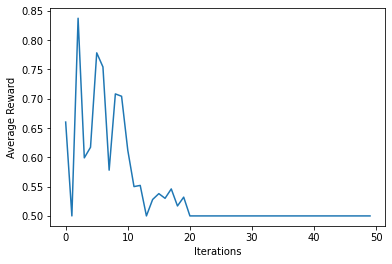

In [1]:
import numpy as np
from scipy.optimize import minimize
#Add random state for reproducibility
np.random.seed(0)
class SimpleMDP:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.transition_probs = np.random.rand(num_states, num_actions, num_states)
        self.transition_probs /= self.transition_probs.sum(axis=2, keepdims=True)
        self.rewards = np.zeros((num_states, num_actions)) + 0.5
        for i in range(num_states):
            for j in range(num_actions):
                if i % 3 == j:
                    self.rewards[i, j] = 1
        self.gamma = 0.95

    def get_reward(self, state, action):
        return self.rewards[state, action]

    def get_transition_probs(self, state, action):
        return self.transition_probs[state, action]

    def next_state(self, state, action):
        return np.random.choice(self.num_states, p=self.transition_probs[state, action])

def initialize_policy(num_states, num_actions):
    return np.full((num_states, num_actions), 1.0 / num_actions)

def compute_bregman_divergence(pi, pi_0):
    if pi.ndim == 1:
        return np.sum(pi * (np.log(pi) - np.log(pi_0 + 1e-10)))
    else:
        return np.sum(pi * (np.log(pi) - np.log(pi_0 + 1e-10)), axis=1)

def update_policy(pi_k, Q, eta_k, num_states, num_actions, pi_0):
    pi_next = np.zeros_like(pi_k)
    for s in range(num_states):
        def objective(p):
            entropy_term = -np.sum(p * np.log(p + 1e-10))
            divergence = compute_bregman_divergence(p, pi_0[s])
            return eta_k * np.dot(Q[s], p) + entropy_term + divergence

        constraints = [
            {'type': 'eq', 'fun': lambda p: np.sum(p) - 1},
            {'type': 'ineq', 'fun': lambda p: p}
        ]
        initial_p = np.full(num_actions, 1.0 / num_actions)
        result = minimize(objective, initial_p, constraints=constraints, method='SLSQP', options={'disp': False})
        if not result.success:
            raise ValueError("Optimization failed: {}".format(result.message))
        pi_next[s] = result.x
        pi_next[s] = result.x
        #Clip pi_next between 0 and 1
        pi_next[s] = np.clip(pi_next[s], 0, 1)
        pi_next[s] = pi_next[s] / sum(pi_next[s])

    return pi_next

def simulate_policy_and_update_q_values(mdp, pi, num_states, num_actions, Q, eta, timesteps=50):
    total_reward = 0
    current_state = np.random.randint(num_states)
    alpha = 0.1

    for _ in range(timesteps):
        action = np.random.choice(num_actions, p=pi[current_state])
        next_state = mdp.next_state(current_state, action)
        reward = mdp.get_reward(current_state, action)
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + mdp.gamma * Q[next_state, best_next_action]
        td_delta = td_target - Q[current_state, action]
        Q[current_state, action] += alpha * td_delta
        current_state = next_state
        total_reward += reward

    return total_reward / timesteps

# Parameters and Initialization
num_states = 5
num_actions = 3
eta_k = 1e-2
num_iterations = 50

mdp = SimpleMDP(num_states, num_actions)
pi_0 = initialize_policy(num_states, num_actions)
pi_k = np.copy(pi_0)
Q = np.zeros((num_states, num_actions))
avg_rewards = []

# PMD Algorithm with experience-based Q-value updates
for k in range(num_iterations):
    pi_k = update_policy(pi_k, Q, eta_k, num_states, num_actions, pi_0)
    avg_reward = simulate_policy_and_update_q_values(mdp, pi_k, num_states, num_actions, Q, eta_k, timesteps=500)\
    print(f"Iteration {k + 1}: Average Cost = {avg_reward:.4f}")
    avg_rewards.append(avg_reward)
print("Final policy:", pi_k)

#Plot graph of avg reward vs iterations
import matplotlib.pyplot as plt
plt.plot(avg_rewards)
plt.xlabel('Iterations')
plt.ylabel('Average Reward')